# Bayesian Inference

Examples of Bayesian Inference for join ILAAPT/INAAPT Spring Meeting April 24, 2021

The `empiricaldist` package is from [Allen B Downey](https://github.com/AllenDowney)

(Binder Link [HERE](https://mybinder.org/v2/gh/sspickle/inaapt-2021/main))


In [1]:
# import some packages we'll need later

import pymc3 as pm  # Markov Chain Monte Carlo
import arviz as az  # visualization
import numpy as np  # numpy
import matplotlib.pyplot as plt # make pretty graphs
import pandas as pd
from empiricaldist import Pmf   # Learn about Bayesian inference. A "Pmf" is a "probability mass function"


In [2]:
# start with a basket of fruit!
A=Pmf({'orange':2, 'apple':5, 'plum':7});
A

,probs
orange,2
apple,5
plum,7


In [3]:
# convert counts to probabilities
A.normalize()
A

,probs
orange,0.142857
apple,0.357143
plum,0.500000


In [4]:
# it's easy to retrieve the probability of an outcome
A['apple']

0.35714285714285715

In [5]:
# We can multiply probabilties by a simple list of numbers and it "does the right thing" for Bayesian work.
A*[1,2,3]

,probs
orange,0.142857
apple,0.714286
plum,1.500000


In [6]:
B=Pmf({'orange':4, 'apple':1, 'plum':12}); 
B.normalize()
B

,probs
orange,0.235294
apple,0.058824
plum,0.705882


In [7]:
A.choice()

'apple'

In [8]:
B.choice()

'orange'

In [9]:
# a nice way to display both baskets together
pd.DataFrame({'A':A, 'B':B})

,A,B
orange,0.142857,0.235294
apple,0.357143,0.058824
plum,0.500000,0.705882


In [10]:
hypotheses = Pmf(1,['A','B'])
hypotheses.normalize()
hypotheses

,probs
A,0.5
B,0.5


In [11]:
data = 'orange'
A[data],B[data]

(0.14285714285714285, 0.23529411764705882)

In [12]:
hypotheses = hypotheses*[A[data],B[data]]
hypotheses.normalize()
hypotheses

,probs
A,0.377778
B,0.622222


In [13]:
data = 'plum'
hypotheses = hypotheses*[A[data],B[data]]
hypotheses.normalize()
hypotheses

,probs
A,0.300728
B,0.699272


In [14]:
data = 'plum'
hypotheses = hypotheses*[A[data],B[data]]
hypotheses.normalize()
hypotheses

,probs
A,0.233497
B,0.766503


In [15]:
for data in B.choice(10):
    hypotheses = hypotheses*[A[data],B[data]]

hypotheses.normalize()
hypotheses

,probs
A,0.066435
B,0.933565


# Machinery to handle continuous distributions

Many times we don't have discrete distributions, but rather continuous random variables. We can fake this with PMFs, but to really get it right, we need something a bit more sophisticated. Here is a simple example of a linear fit using randomly generated data to illustrate the pymc3 machinery.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


      mean     sd  hdi_3%  hdi_97%
mu   2.072  0.123   1.846    2.309
sig  0.551  0.096   0.386    0.725


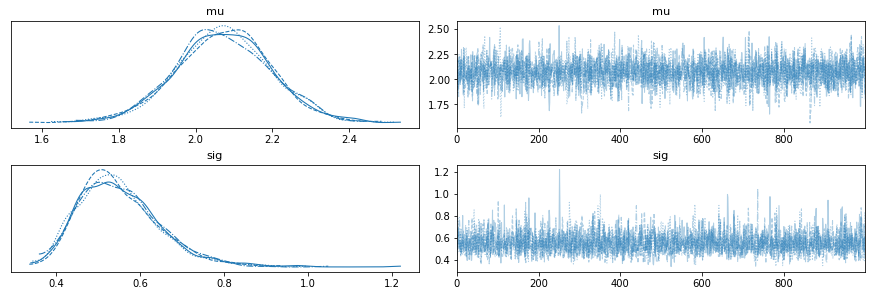

In [16]:
# generative model, simple normal distribution

x1 = np.random.normal(size=20)*.5 + 2

with pm.Model() as normal_model:
    mu = pm.Normal('mu',mu=0,sigma=5)  # prior distribution for mu
    sig = pm.HalfNormal('sig',sigma=2) # prior distribution for sigma
    
    x_obs = pm.Normal("x_obs", mu=mu, sigma=sig, observed=x1) # relationship to observed data
    trace = pm.sample(1000, return_inferencedata=True)
    
print(az.summary(trace, kind="stats"))
_=az.plot_trace(trace)

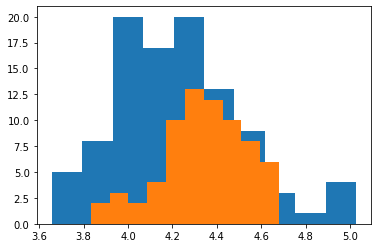

In [17]:
x1 = np.random.normal(size=100)*.3+4.1
x2 = np.random.normal(size=70)*.2+4.3

_=plt.hist(x1)
_=plt.hist(x2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig2, sig1, mu2, mu1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


         mean     sd  hdi_3%  hdi_97%
mu1     4.226  0.029   4.175    4.286
mu2     4.342  0.024   4.297    4.387
sig1    0.290  0.021   0.254    0.332
sig2    0.196  0.017   0.164    0.228
x_diff  0.116  0.038   0.047    0.187


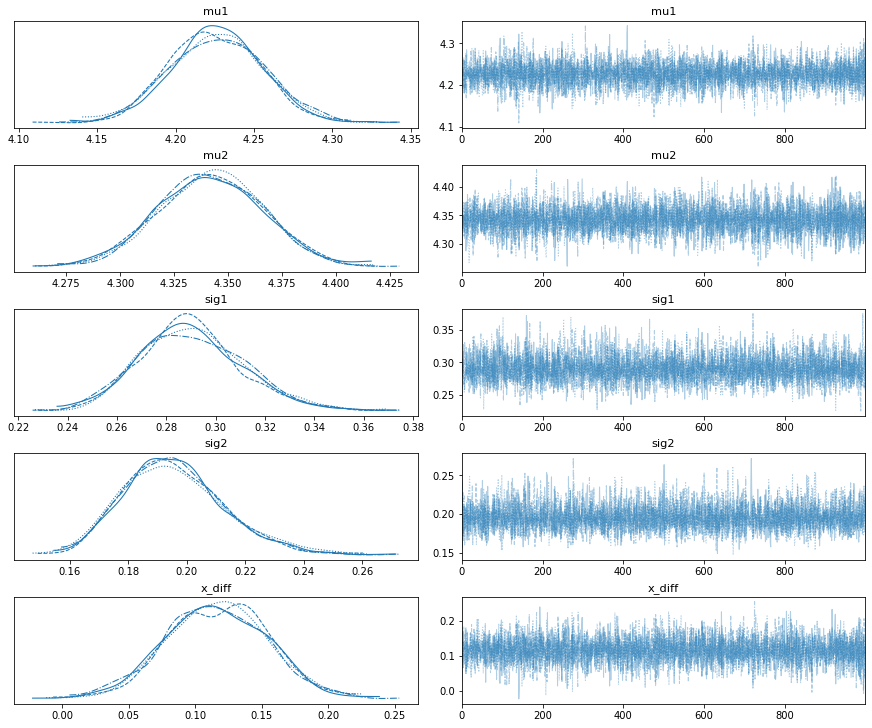

In [18]:
with pm.Model() as diff_model:
    mu1 = pm.Uniform('mu1',0,10)  # prior distribution for mu1
    mu2 = pm.Uniform('mu2',0,10)  # prior for mu2
    sig1 = pm.HalfNormal('sig1',sigma=2) # prior distribution for sigma1
    sig2 = pm.HalfNormal('sig2',sigma=2) # prior distribution for sigma2
    
    x1_obs = pm.Normal("x1_obs", mu=mu1, sigma=sig1, observed=x1) # relationship to observed data
    x2_obs = pm.Normal("x2_obs", mu=mu2, sigma=sig2, observed=x2) # relationship to observed data

    diff = pm.Deterministic("x_diff", mu2 - mu1)

    trace = pm.sample(1000, return_inferencedata=True)
    
print(az.summary(trace, kind="stats"))
_=az.plot_trace(trace)

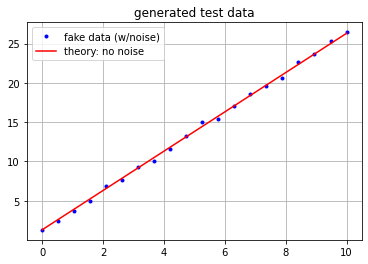

In [19]:
x = np.linspace(0,10,20)
m_gen = 2.5
b_gen = 1.3
s_gen = 0.3

y_th = m_gen*x + b_gen
y_noise = y_th + s_gen*np.random.normal(size=(len(x))) # y = m*x + b + noise

plt.plot(x,y_noise,'b.',label='fake data (w/noise)')
plt.plot(x,y_th,'r-',label='theory: no noise')
plt.title('generated test data')
plt.grid()
plt.legend()

In [20]:
with pm.Model() as model:
    m = pm.Uniform('m',0,5)  # prior distribution for m
    b = pm.Uniform('b',0,5)  # prior distribution for b
    s = pm.Uniform('s',0,2)  # prior distribution for s
    
    y_obs = pm.Normal('y_obs',mu=m*x+b, sigma=s, observed=y_noise) # relate to measured values


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, b, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.7071580503053225, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


    mean     sd  hdi_3%  hdi_97%
m  2.526  0.023   2.482    2.566
b  1.148  0.132   0.900    1.390
s  0.300  0.060   0.197    0.411


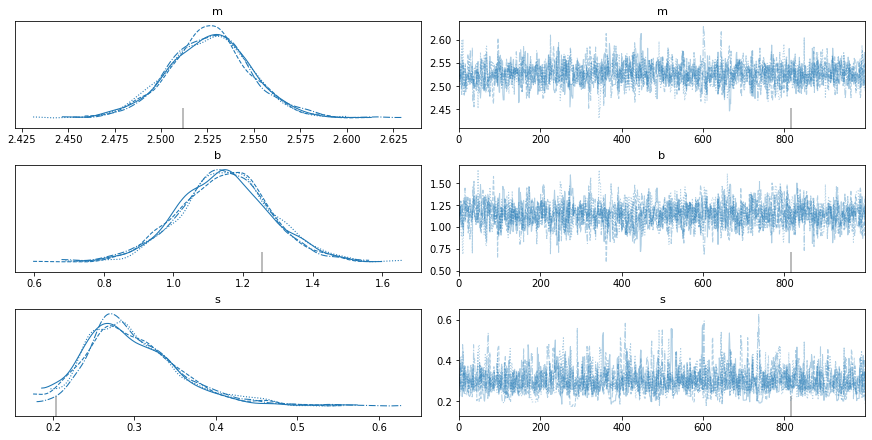

In [21]:
with model:
    trace = pm.sample(1000, return_inferencedata=True)
    
print(az.summary(trace, kind="stats"))
_=az.plot_trace(trace)

In [22]:
# It's useful to inspect the resulting trace object

trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

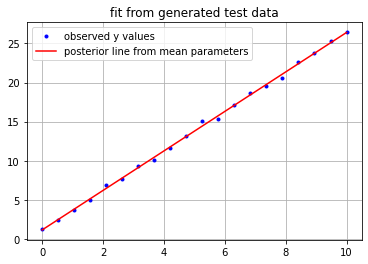

In [23]:
y_post = trace.posterior.m.values.mean()*x + trace.posterior.b.values.mean()
plt.plot(x,y_noise,'b.',label='observed y values')
plt.plot(x,y_post,'r-',label='posterior line from mean parameters')
plt.title('fit from generated test data')
plt.grid()
plt.legend()

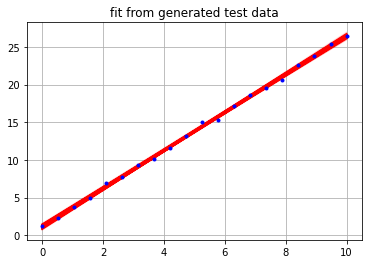

In [24]:
all_m = trace.posterior.m.values.flatten()
all_b = trace.posterior.b.values.flatten()

N = 1000

for i in range(N):
    y_post = all_m[i]*x + all_b[i]
    plt.plot(x,y_post,'r-',alpha=0.1)
    
plt.plot(x,y_noise,'b.',label='observed y values')
plt.title('fit from generated test data')
plt.grid()


In [25]:
import matplotlib

print("pymc3 is version {:s}".format(pm.__version__))
print("arviz is version {:s}".format(az.__version__))
print("numpy is version {:s}".format(np.__version__))
print("pandas is version {:s}".format(pd.__version__))
print("matplotlib is version {:s}".format(matplotlib.__version__))

pymc3 is version 3.11.2
arviz is version 0.11.2
numpy is version 1.20.2
pandas is version 1.2.4
matplotlib is version 3.4.1
